# Problema de Negócio

Uma empresa alimentícia situada no RJ deseja abrir filiais na cidade de
São Paulo, tendo como público alvo adultos de 25 a 50 anos, das
classes A (rendas A1 e A2) e B (rendas B1 e B2).

Essa empresa já atua no Rio de Janeiro e antes de fazer o investimento
quer estimar quanto poderia faturar em cada um dos bairros de São
Paulo também. Como o mercado de São Paulo não é bem conhecido para essa
empresa, ela deseja classificar os bairros de São Paulo para saber se o
potencial é alto, médio ou baixo. Utilizando como base o potencial que
ela já conhece dos bairros do Rio de Janeiro.

Os analistas dessa empresa também gostariam de segmentar os bairros
de São Paulo de acordo com o perfil de renda e idade para direcionar
ações de marketing diferenciadas

# Estratégia de Solução

1. Fazer um modelo de Regressão para prever o faturamento
2. Usar os dados de faturamento calculadas pelo algoritmo de Regressão e usar um modelo de classificação para classificar o potencial em Alto, Médio, Baixo. 
3. Usar os dados anteriores para segmentar os clientes baseado no público alvo da empresa.

# 0.0 IMPORTS

In [12]:
import pandas                  as pd
import numpy                   as np
import seaborn                 as sns
import matplotlib.pyplot       as plt
import sklearn.preprocessing   as pp

import umap.umap_              as umap

import sklearn.metrics         as mt
import sklearn.model_selection as ms 

from sklearn.dummy         import DummyRegressor
from sklearn.impute        import SimpleImputer
from sklearn.linear_model  import LinearRegression, LogisticRegression
from sklearn.svm           import SVR, SVC
from sklearn.neighbors     import KNeighborsRegressor
from sklearn.tree          import DecisionTreeRegressor
from sklearn.ensemble      import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors     import KNeighborsClassifier
from sklearn.mixture       import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold      import TSNE

from scipy.cluster         import hierarchy as hc

from xgboost               import XGBRegressor, XGBClassifier
from lightgbm              import LGBMRegressor, LGBMClassifier
from catboost              import CatBoostRegressor, CatBoostClassifier
from sklearn.cluster       import KMeans
from yellowbrick.cluster   import SilhouetteVisualizer


import inflection
import skopt
import warnings

warnings.filterwarnings('ignore')

## 0.1 Loading Data

In [13]:
path = 'C://Users/edils/repos/desafio_geo/data/'
df_raw = pd.read_csv(path + 'X_train.csv', encoding='ISO-8859-1', sep=';')

In [14]:
df_train = df_raw.loc[df_raw['cidade'] == 'Rio de Janeiro']

In [15]:
X_test = df_raw.loc[df_raw['cidade'] == 'São Paulo']

## 0.2 Helper Functions

In [16]:
def rename_columns(df1):
    cols_new = df1.columns.map(lambda x: inflection.underscore(x))
    df1.columns = cols_new
    
    return df1

def replace_strings(valor):
    if isinstance(valor, str):
        return np.nan
    return valor


def change_types(df1):
    
    df1['renda_media'] = df1['renda_media'].astype(float)


def pre_processing(df4):
    #minmax
    columns_minmax = ['população', 'pop_ate9', 'pop_de10a14', 'pop_de15a19',
       'pop_de20a24', 'pop_de25a34', 'pop_de35a49', 'pop_de50a59',
       'pop_mais_de60', 'domicilios_a1', 'domicilios_a2', 'domicilios_b1',
       'domicilios_b2', 'domicilios_c1', 'domicilios_c2', 'domicilios_d',
       'domicilios_e', 'renda_media']

    mms = pp.MinMaxScaler()

    for col in columns_minmax:
        df4[col] = mms.transform(df4[col].values.reshape(-1,1))
    
    #standard
    ss = pp.StandardScaler()

    df4['faturamento'] = ss.transform(df4['faturamento'].values.reshape(-1,1))
    
    return df4

def regression_error(model, y, yhat):
    
    mae = mt.mean_absolute_error(y, yhat)
    mape = mt.mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mt.mean_squared_error(y, yhat))
        
    df = pd.DataFrame({
        'Modelo':model.__name__,
        'MAE':mae,
        'MAPE':mape,
        'RMSE':rmse
        
    }, index=[0])
    
    return df

def classification_metrics(model, y_true, y_pred):
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision_micro = mt.precision_score(y_true, y_pred, average='micro')
    recall_micro = mt.recall_score(y_true, y_pred, average='micro')
    f1_micro = mt.f1_score(y_true, y_pred, average='micro')
    precision_macro = mt.precision_score(y_true, y_pred, average='macro')
    recall_macro = mt.recall_score(y_true, y_pred, average='macro')
    f1_macro = mt.f1_score(y_true, y_pred, average='macro')
    
    df = pd.DataFrame({
        'Modelo': [model.__name__],
        'Accuracy': [accuracy],
        'Precision (micro)': [precision_micro],
        'Recall (micro)': [recall_micro],
        'F1 Score (micro)': [f1_micro],
        'Precision (macro)': [precision_macro],
        'Recall (macro)': [recall_macro],
        'F1 Score (macro)': [f1_macro]
    })
    
    return df

palette = ["#00BFFF", "#DC143C", "#FFA07A", "#FFD700", "#8B008B", "#7CFC00", "#FF69B4", "#00CED1", "#FF6347", "#9400D3"]
def jupyter_settings(palette):
    %matplotlib inline
    plt.style.use( 'seaborn-v0_8' )
    plt.rcParams['figure.figsize'] = [12, 6]
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 50
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set(font_scale=2)
    sns.set_theme()
    warnings.simplefilter("ignore")
    # plt.rcParams.update({'font.size': 10})
    sns.set_style("darkgrid")

    
jupyter_settings(palette)   

# 1.0 DATA DESCRIPTION

In [17]:
df1 = df_train.copy()

In [18]:
df1.head()

,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial
0,3304557060,Abolição,Rio de Janeiro,RJ,11676,1027,483,688,800,1675,2300,1784,2919,0,145,715,1242,1093,758,92,304,2501,932515.0,Médio
1,3304557138,Acari,Rio de Janeiro,RJ,27564,5131,2188,2697,2630,4810,5308,2403,2397,0,0,82,506,2040,2490,827,2506,931,588833.0,Baixo
2,3304557057,Água Santa,Rio de Janeiro,RJ,9003,883,399,597,762,1755,2076,1112,1419,0,96,404,652,644,522,77,254,2391,874200.0,Baixo
3,3304557031,Alto Da Boa Vista,Rio de Janeiro,RJ,9606,1072,538,660,685,1317,2007,1341,1986,114,178,393,517,945,584,137,286,3727,912226.0,Médio
4,3304557125,Anchieta,Rio de Janeiro,RJ,57222,7677,3774,4892,4600,8660,12272,7157,8190,0,0,1089,2821,5110,5422,1073,3261,1380,553020.0,Médio


## 1.1 Rename Columns

In [19]:
cols_new = df1.columns.map(lambda x: inflection.underscore(x))
df1.columns = cols_new

## 1.2 Data Shape

In [20]:
df1.shape

(160, 24)

## 1.3 Data Types

In [21]:
df1.dtypes

codigo             int64
nome              object
cidade            object
estado            object
população          int64
pop_ate9           int64
pop_de10a14        int64
pop_de15a19        int64
pop_de20a24        int64
pop_de25a34        int64
pop_de35a49        int64
pop_de50a59        int64
pop_mais_de60      int64
domicilios_a1      int64
domicilios_a2      int64
domicilios_b1      int64
domicilios_b2      int64
domicilios_c1      int64
domicilios_c2      int64
domicilios_d       int64
domicilios_e       int64
renda_media       object
faturamento      float64
potencial         object
dtype: object

In [22]:
df1['renda_media'] = df1['renda_media'].astype(float)

## 1.3 Check NaN

In [23]:
df1.isna().sum()

codigo           0
nome             0
cidade           0
estado           0
população        0
pop_ate9         0
pop_de10a14      0
pop_de15a19      0
pop_de20a24      0
pop_de25a34      0
pop_de35a49      0
pop_de50a59      0
pop_mais_de60    0
domicilios_a1    0
domicilios_a2    0
domicilios_b1    0
domicilios_b2    0
domicilios_c1    0
domicilios_c2    0
domicilios_d     0
domicilios_e     0
renda_media      6
faturamento      0
potencial        0
dtype: int64

In [24]:
df1['renda_media'] = df1['renda_media'].fillna(df1['renda_media'].mean())

## 1.5 Descriptive Statistics

### 1.5.1 Numerical Statistics

In [25]:
num_attributes = df1.select_dtypes(include=['int64','float64'])

In [26]:
disp = num_attributes.agg(['min', 'max', lambda x: max(x)-min(x), 'mean','median','std','skew','kurtosis']).T
disp = disp.rename(columns={'<lambda>':'range'})

In [27]:
disp

,min,max,range,mean,median,std,skew,kurtosis
codigo,3.304557e+09,3.304557e+09,159.0,3.304557e+09,3.304557e+09,46.332134,0.000000,-1.200000
população,1.730000e+02,6.676030e+05,667430.0,4.265435e+04,2.607600e+04,64262.949072,6.430261,56.987523
pop_ate9,3.300000e+01,1.225780e+05,122545.0,5.329062e+03,3.111500e+03,10816.199770,8.455441,87.995016
pop_de10a14,1.300000e+01,5.593500e+04,55922.0,2.484444e+03,1.434000e+03,4948.827166,8.385443,86.769750
pop_de15a19,2.200000e+01,6.234200e+04,62320.0,3.272156e+03,2.015000e+03,5752.156303,7.401606,71.038687
pop_de20a24,1.700000e+01,6.056700e+04,60550.0,3.349381e+03,2.142500e+03,5601.893201,7.253694,69.287685
pop_de25a34,2.800000e+01,8.611600e+04,86088.0,6.584475e+03,4.170500e+03,9049.895783,5.159097,38.471855
pop_de35a49,3.800000e+01,1.053160e+05,105278.0,8.826862e+03,5.657000e+03,11536.276416,4.691357,32.096439
pop_de50a59,1.000000e+01,8.334100e+04,83331.0,5.332262e+03,3.371500e+03,7986.261929,6.495919,57.988745
pop_mais_de60,1.200000e+01,9.140800e+04,91396.0,7.475706e+03,4.575500e+03,10258.307743,4.725239,30.969842


Aparentemente os dados são regulares, não há indícios de outliers ou valores fora do normal.

### 1.5.2 Categorical Attributes

In [28]:
cat_attributes = df1.select_dtypes(exclude=['int64','float64'])

In [29]:
cat_attributes

,nome,cidade,estado,potencial
0,Abolição,Rio de Janeiro,RJ,Médio
1,Acari,Rio de Janeiro,RJ,Baixo
2,Água Santa,Rio de Janeiro,RJ,Baixo
3,Alto Da Boa Vista,Rio de Janeiro,RJ,Médio
4,Anchieta,Rio de Janeiro,RJ,Médio
...,...,...,...,...
155,Vila Kosmos,Rio de Janeiro,RJ,Médio
156,Vila Militar,Rio de Janeiro,RJ,Médio
157,Vila Valqueire,Rio de Janeiro,RJ,Alto
158,Vista Alegre,Rio de Janeiro,RJ,Baixo


<Axes: xlabel='potencial', ylabel='count'>

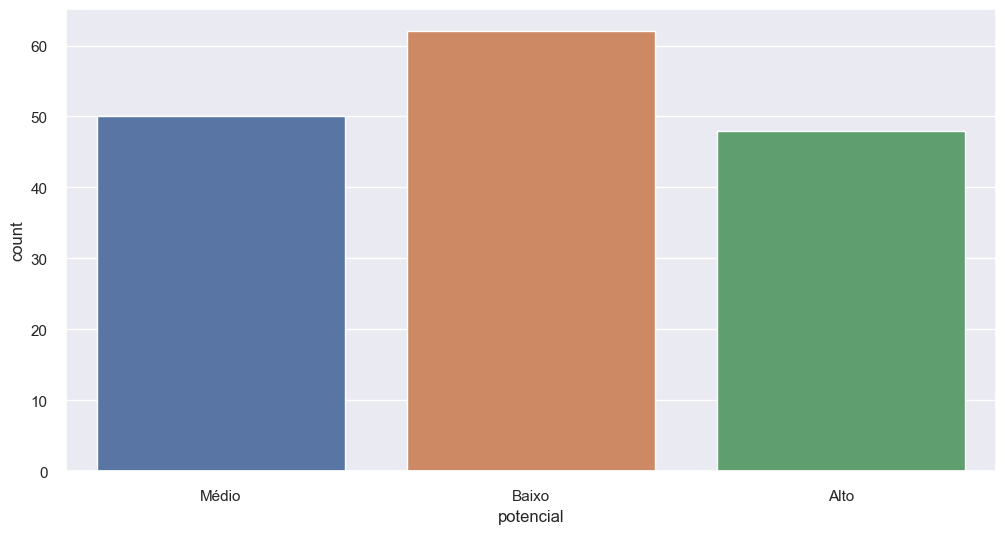

In [30]:
#name 
sns.countplot(cat_attributes, x='potencial')

Os dados de potencial são bem balanceados.

# 2.0 FEATURE ENGINEERING

In [31]:
df2 = df1.copy()

In [32]:
#remove city, state, ID
df2 = df2.drop(['cidade', 'estado', 'codigo'], axis=1)

In [33]:
df2.columns

Index(['nome', 'população', 'pop_ate9', 'pop_de10a14', 'pop_de15a19',
       'pop_de20a24', 'pop_de25a34', 'pop_de35a49', 'pop_de50a59',
       'pop_mais_de60', 'domicilios_a1', 'domicilios_a2', 'domicilios_b1',
       'domicilios_b2', 'domicilios_c1', 'domicilios_c2', 'domicilios_d',
       'domicilios_e', 'renda_media', 'faturamento', 'potencial'],
      dtype='object')

In [34]:
df2.head()

,nome,população,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,faturamento,potencial
0,Abolição,11676,1027,483,688,800,1675,2300,1784,2919,0,145,715,1242,1093,758,92,304,2501.0,932515.0,Médio
1,Acari,27564,5131,2188,2697,2630,4810,5308,2403,2397,0,0,82,506,2040,2490,827,2506,931.0,588833.0,Baixo
2,Água Santa,9003,883,399,597,762,1755,2076,1112,1419,0,96,404,652,644,522,77,254,2391.0,874200.0,Baixo
3,Alto Da Boa Vista,9606,1072,538,660,685,1317,2007,1341,1986,114,178,393,517,945,584,137,286,3727.0,912226.0,Médio
4,Anchieta,57222,7677,3774,4892,4600,8660,12272,7157,8190,0,0,1089,2821,5110,5422,1073,3261,1380.0,553020.0,Médio


# 3.0 EDA

In [35]:
df3 = df2.copy()

## 3.1 Lista de Hipóteses

1. Hipótese de correlação entre população e faturamento: Bairros com maior população têm maior potencial de faturamento, uma vez que têm um público maior para atrair.

2. Hipótese de correlação entre renda média e faturamento: Bairros com maior renda média tendem a ter maior potencial de faturamento, pois as pessoas com renda mais alta têm mais poder de compra.

3. Hipótese de correlação entre faixa etária e faturamento: A distribuição da população em diferentes faixas etárias pode afetar o faturamento. Por exemplo, bairros com uma proporção maior de adultos de 25 a 50 anos (público-alvo) podem ter maior potencial de faturamento.

4. Hipótese do Domicílio: Bairros com domicílio de alto padrão tendem a ter um faturamento maior

5. Relação entre Potencial e Faturamento: Quanto maior o faturamento maior o Potencial

## 3.2 H1 - Hipótese de correlação entre população e faturamento.

<Axes: >

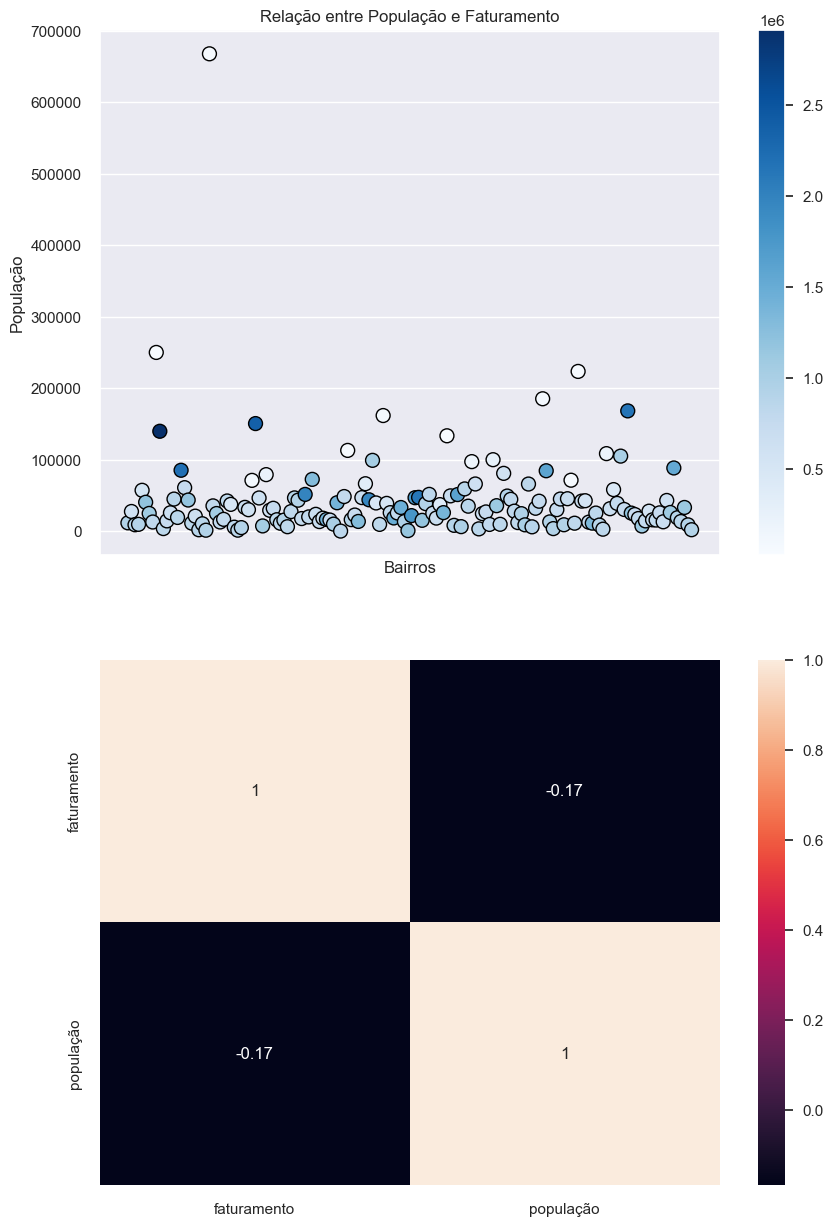

In [36]:
plt.figure(figsize=(10,15))

plt.subplot(2,1,1)
plt.scatter(df3['nome'], df3['população'], s=100, linewidths=1, c=df3['faturamento'], cmap='Blues', edgecolors='black')
plt.colorbar()
plt.xlabel('Bairros')
plt.ylabel('População')
plt.title('Relação entre População e Faturamento')

plt.xticks([])

plt.subplot(2,1,2)
df_corr = df3.loc[:,['faturamento','população']]
sns.heatmap(df_corr.corr(), annot=True)

FALSO. Alguns dos bairros com maior faturamento não possuem uma população entre as maiores

## 3.3 H2 - Hipótese de correlação entre renda média e faturamento.

<Axes: >

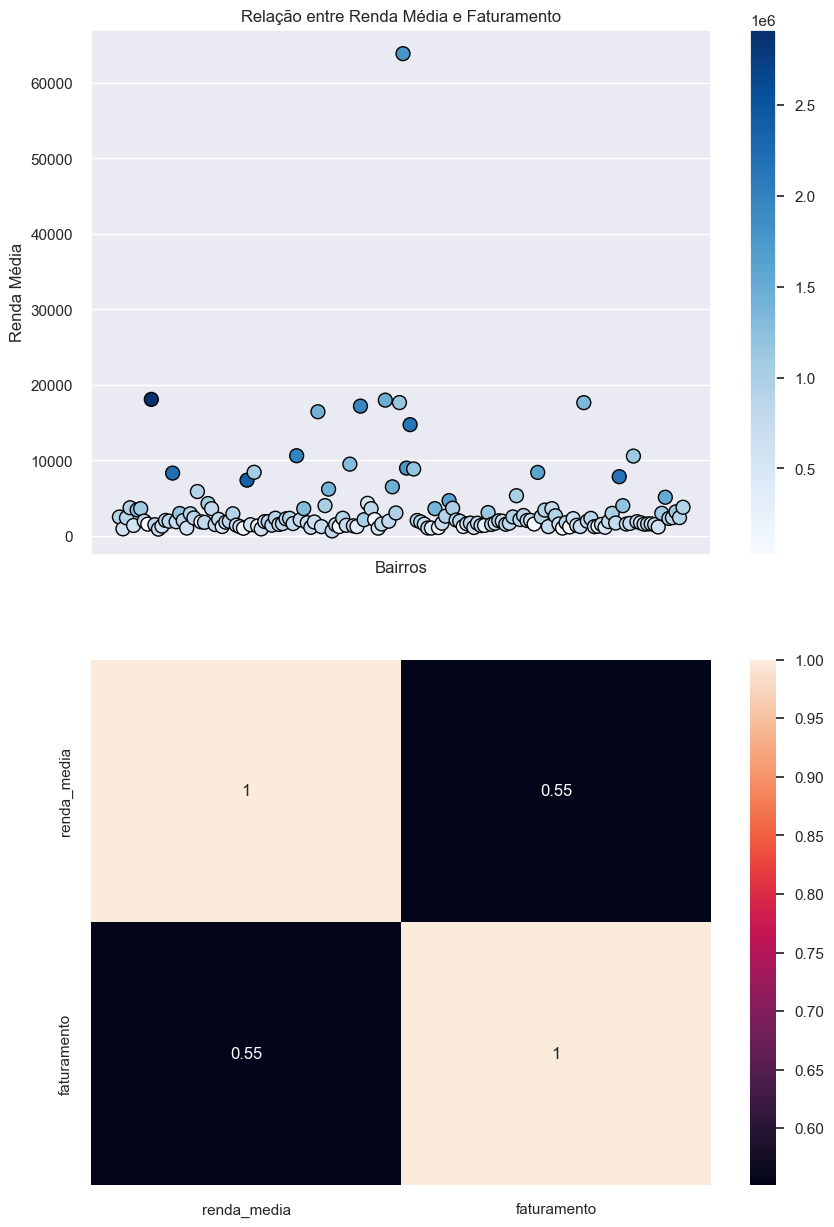

In [37]:
plt.figure(figsize=(10,15))

plt.subplot(2,1,1)
plt.scatter(df3['nome'], df3['renda_media'], s=100, linewidths=1, c=df3['faturamento'], cmap='Blues', edgecolors='black')
plt.colorbar()
plt.xlabel('Bairros')
plt.ylabel('Renda Média')
plt.title('Relação entre Renda Média e Faturamento')

plt.xticks([])

plt.subplot(2,1,2)
df_corr = df3.loc[:,['renda_media','faturamento']]
sns.heatmap(df_corr.corr(), annot=True)

VERDADEIRO - Os bairros mais claros estão na parte de baixos enquantos os mais escuros na parte de cima

## 3.4 H3 - Hipótese de correlação entre faixa etária e potencial.

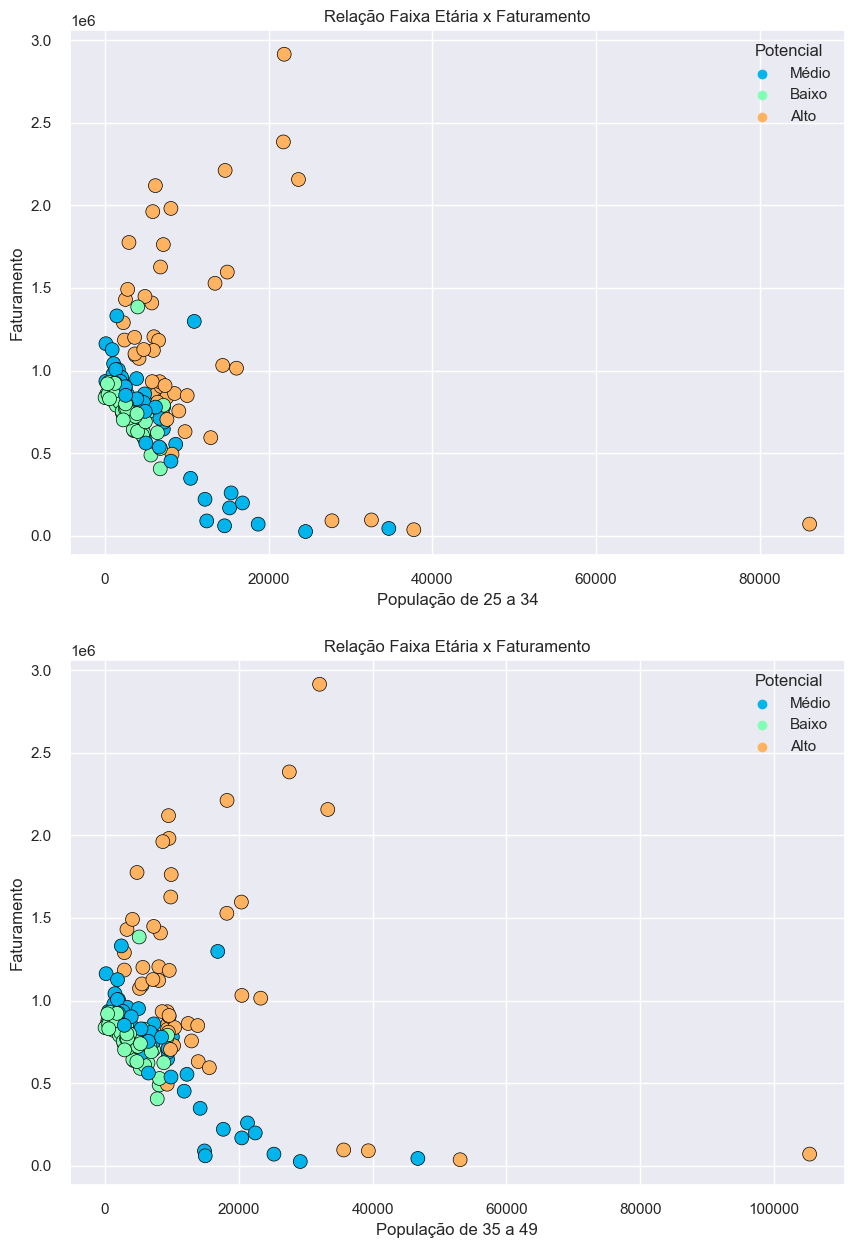

In [38]:
plt.figure(figsize=(10,15))

plt.subplot(2,1,1)
sns.scatterplot(data=df3, x='pop_de25a34', y='faturamento', hue=df3['potencial'], s=100, palette='rainbow', edgecolor='black', linewidth=0.5)

plt.xlabel('População de 25 a 34')
plt.ylabel('Faturamento')
plt.title('Relação Faixa Etária x Faturamento')

plt.legend(title='Potencial')

plt.subplot(2,1,2)
sns.scatterplot(data=df3, x='pop_de35a49', y='faturamento', hue=df3['potencial'], s=100, palette='rainbow', edgecolor='black', linewidth=0.5)

plt.xlabel('População de 35 a 49')
plt.ylabel('Faturamento')
plt.title('Relação Faixa Etária x Faturamento')

plt.legend(title='Potencial')


## 3.5 H4 - Hipótese do Domicílio: Bairros com domicílio de alto padrão tendem a ter um faturamento maior

Text(0.5, 1.0, 'Domicilios E')

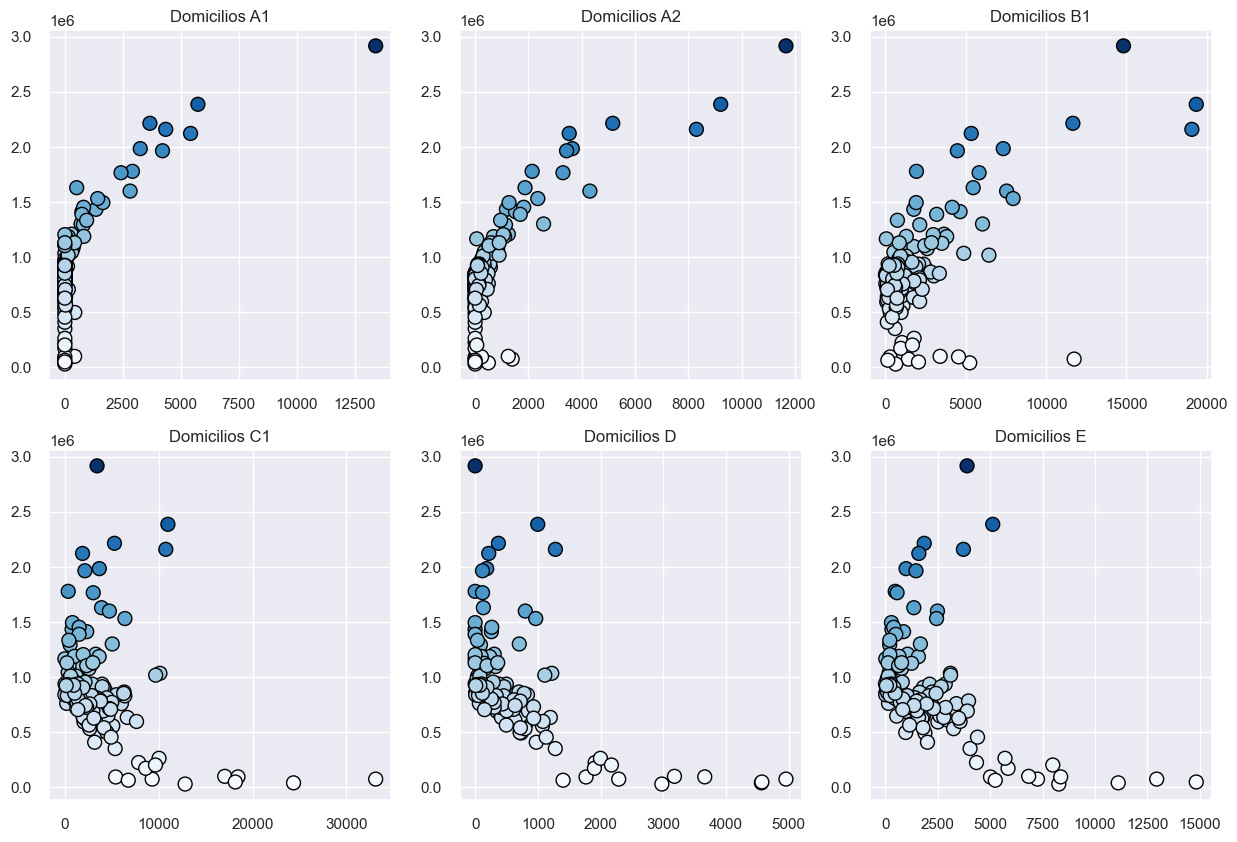

In [39]:
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.scatter(df3['domicilios_a1'], df3['faturamento'], s=100, linewidths=1, c=df3['faturamento'], cmap='Blues', edgecolors='black')
plt.title('Domicilios A1')

plt.subplot(2,3,2)
plt.scatter(df3['domicilios_a2'], df3['faturamento'], s=100, linewidths=1, c=df3['faturamento'], cmap='Blues', edgecolors='black')
plt.title('Domicilios A2')


plt.subplot(2,3,3)
plt.scatter(df3['domicilios_b1'], df3['faturamento'], s=100, linewidths=1, c=df3['faturamento'], cmap='Blues', edgecolors='black')
plt.title('Domicilios B1')


plt.subplot(2,3,4)
plt.scatter(df3['domicilios_c1'], df3['faturamento'], s=100, linewidths=1, c=df3['faturamento'], cmap='Blues', edgecolors='black')
plt.title('Domicilios C1')


plt.subplot(2,3,5)
plt.scatter(df3['domicilios_d'], df3['faturamento'], s=100, linewidths=1, c=df3['faturamento'], cmap='Blues', edgecolors='black')
plt.title('Domicilios D')


plt.subplot(2,3,6)
plt.scatter(df3['domicilios_e'], df3['faturamento'], s=100, linewidths=1, c=df3['faturamento'], cmap='Blues', edgecolors='black')
plt.title('Domicilios E')


VERDADEIRO - Nos domicílios de alto padrão, aumentar a quantidade de domicilios aumenta o faturamento, já nos de baixo padrão, não.

## 3.5 H5 - Relação entre Potencial e Faturamento: Quanto maior o faturamento maior o Potencial

In [40]:
df3_hip = df3.copy()
df3_hip['potencial'] = df3['potencial'].apply(lambda x: 0 if x == 'Baixo' else 1 if x == 'Médio' else 2)

<Axes: >

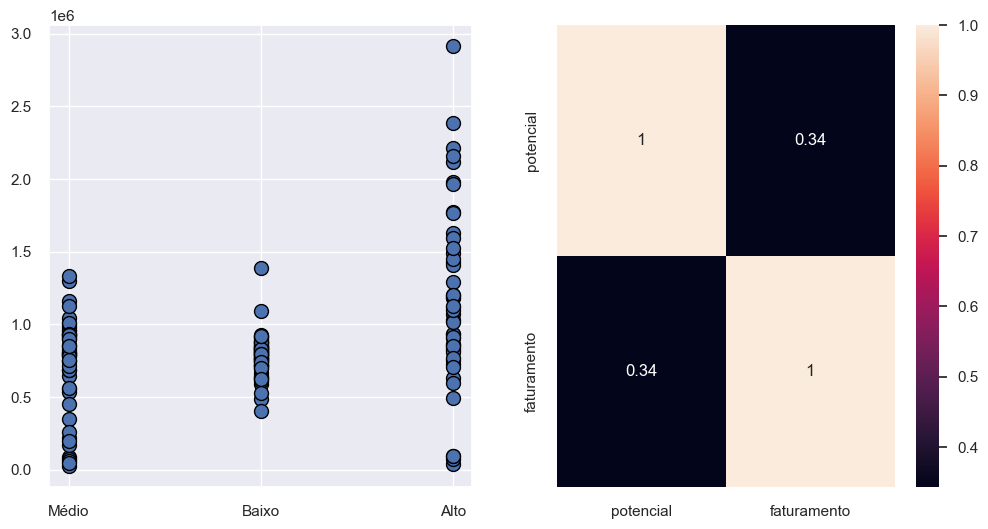

In [41]:

plt.subplot(1,2,1)
plt.scatter(df3['potencial'], df3['faturamento'], s=100, linewidths=1, edgecolors='black')

plt.subplot(1,2,2)
df_corr = df3_hip.loc[:,['potencial','faturamento']]
sns.heatmap(df_corr.corr(), annot=True)

# 4.0 DATA PREPARATION

In [42]:
df4 = df3.copy()

In [43]:
df4.head()

,nome,população,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,faturamento,potencial
0,Abolição,11676,1027,483,688,800,1675,2300,1784,2919,0,145,715,1242,1093,758,92,304,2501.0,932515.0,Médio
1,Acari,27564,5131,2188,2697,2630,4810,5308,2403,2397,0,0,82,506,2040,2490,827,2506,931.0,588833.0,Baixo
2,Água Santa,9003,883,399,597,762,1755,2076,1112,1419,0,96,404,652,644,522,77,254,2391.0,874200.0,Baixo
3,Alto Da Boa Vista,9606,1072,538,660,685,1317,2007,1341,1986,114,178,393,517,945,584,137,286,3727.0,912226.0,Médio
4,Anchieta,57222,7677,3774,4892,4600,8660,12272,7157,8190,0,0,1089,2821,5110,5422,1073,3261,1380.0,553020.0,Médio


In [44]:
#potencial
df4['potencial'] = df4['potencial'].apply(lambda x: 0 if x == 'Baixo' else 1 if x == 'Médio' else 2)

<Axes: xlabel='faturamento', ylabel='Count'>

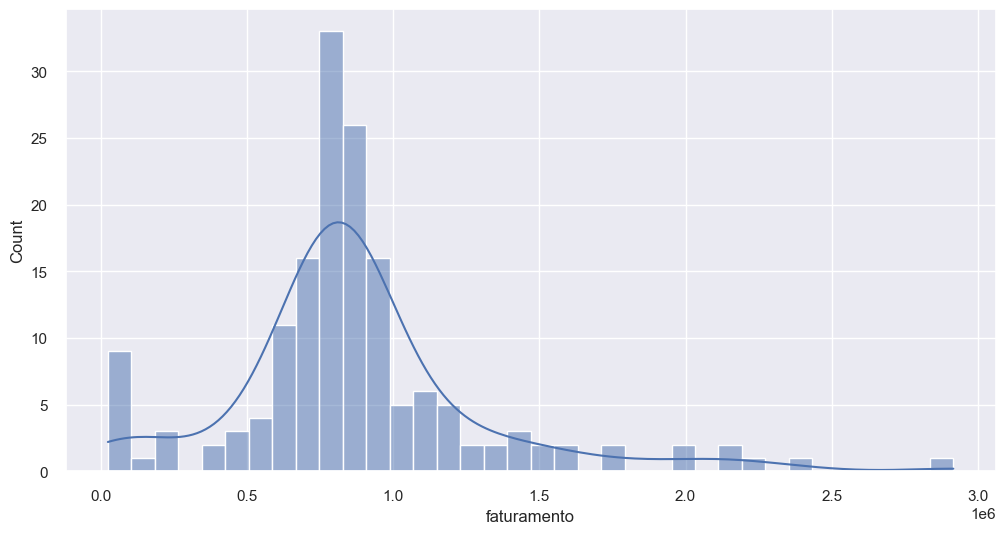

In [45]:
sns.histplot(df4, x='faturamento', kde=True)

## 4.1 MinMaxScaler

In [46]:
df4.columns

Index(['nome', 'população', 'pop_ate9', 'pop_de10a14', 'pop_de15a19',
       'pop_de20a24', 'pop_de25a34', 'pop_de35a49', 'pop_de50a59',
       'pop_mais_de60', 'domicilios_a1', 'domicilios_a2', 'domicilios_b1',
       'domicilios_b2', 'domicilios_c1', 'domicilios_c2', 'domicilios_d',
       'domicilios_e', 'renda_media', 'faturamento', 'potencial'],
      dtype='object')

In [47]:
columns_minmax = ['população', 'pop_ate9', 'pop_de10a14', 'pop_de15a19',
       'pop_de20a24', 'pop_de25a34', 'pop_de35a49', 'pop_de50a59',
       'pop_mais_de60', 'domicilios_a1', 'domicilios_a2', 'domicilios_b1',
       'domicilios_b2', 'domicilios_c1', 'domicilios_c2', 'domicilios_d',
       'domicilios_e', 'renda_media']

mms = pp.MinMaxScaler()

for col in columns_minmax:
    df4[col] = mms.fit_transform(df4[col].values.reshape(-1,1))

## 4.2 StandScaler

In [48]:
ss = pp.StandardScaler()

df4['faturamento'] = ss.fit_transform(df4['faturamento'].values.reshape(-1,1))

# 5.0 FEATURE SELECTION

In [49]:
df5 = df4.copy()

In [50]:
df5.head()

,nome,população,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,faturamento,potencial
0,Abolição,0.017235,0.008111,0.008405,0.010687,0.012931,0.019132,0.021486,0.021289,0.031807,0.000000,0.012427,0.036951,0.058483,0.032864,0.029291,0.018563,0.020363,0.029209,0.129006,1
1,Acari,0.041040,0.041601,0.038893,0.042924,0.043154,0.055548,0.050058,0.028717,0.026095,0.000000,0.000000,0.004238,0.023826,0.061469,0.096485,0.166868,0.168836,0.004381,-0.657741,0
2,Água Santa,0.013230,0.006936,0.006902,0.009227,0.012304,0.020061,0.019358,0.013224,0.015395,0.000000,0.008228,0.020879,0.030701,0.019302,0.020135,0.015537,0.016991,0.027470,-0.004487,0
3,Alto Da Boa Vista,0.014133,0.008479,0.009388,0.010237,0.011032,0.014973,0.018703,0.015972,0.021598,0.008502,0.015255,0.020310,0.024344,0.028394,0.022540,0.027643,0.019149,0.048598,0.082561,1
4,Anchieta,0.085476,0.062377,0.067254,0.078145,0.075690,0.100269,0.116207,0.085766,0.089479,0.000000,0.000000,0.056279,0.132834,0.154202,0.210234,0.216505,0.219742,0.011481,-0.739723,1


## 5.1 Random Forest Selection

In [51]:
X_train = df5.drop(['nome','faturamento','potencial'], axis=1).copy()
y_train = df5['faturamento'].copy()

In [52]:
rf = RandomForestRegressor(n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [53]:
importances = rf.feature_importances_
columns_importances = X_train.columns

In [54]:
importance_dict = {}
for key, value in zip(columns_importances, importances):
    importance_dict[key] = value
    
df_importance = pd.DataFrame(importance_dict, index=[0]).T.rename(columns={0:'Ranking'})

In [55]:
df_importance.sort_values(by='Ranking', ascending=False)

,Ranking
domicilios_a1,0.543147
domicilios_e,0.141178
domicilios_a2,0.136476
renda_media,0.049706
domicilios_d,0.045564
pop_ate9,0.031288
pop_mais_de60,0.011455
domicilios_c2,0.008840
pop_de10a14,0.005140
domicilios_b1,0.004283


# 6.0 Machine Learning Regression

## 6.1 Split Test and Training

In [56]:
X_train = df5.drop(['nome','faturamento','potencial', 'população'], axis=1).copy()
y_train = df5['faturamento'].copy()

In [57]:
model_list = [DummyRegressor,
              LinearRegression, 
              SVR,  
              RandomForestRegressor, 
              XGBRegressor, 
              LGBMRegressor,
              CatBoostRegressor]

In [58]:
for model in model_list:
    if model.__name__ == 'CatBoostRegressor':
        mds = model(verbose=False)
    else:
        mds = model()
    kfold = ms.KFold(n_splits=10)
    s = ms.cross_val_score(mds, X_train, y_train, scoring='r2', cv=kfold)
    print(f"{model.__name__:22} R2 Score: {s.mean():.3f} +/- {s.std():.3f} ")

DummyRegressor         R2 Score: -0.101 +/- 0.128 
LinearRegression       R2 Score: 0.018 +/- 2.374 
SVR                    R2 Score: 0.694 +/- 0.346 
RandomForestRegressor  R2 Score: 0.878 +/- 0.109 
XGBRegressor           R2 Score: 0.909 +/- 0.054 
LGBMRegressor          R2 Score: 0.682 +/- 0.312 
CatBoostRegressor      R2 Score: 0.915 +/- 0.064 


## 6.2 Split Training Validation

In [59]:
X_train = df3.drop(['nome','faturamento','potencial', 'população'], axis=1).copy()
y_train = df3['faturamento'].copy()
X_train_reg, X_val, y_train_reg, y_val = ms.train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## 6.2 Dummy Regressor - Baseline

In [60]:
model_dummy = DummyRegressor()

model_dummy.fit(X_train_reg, y_train_reg)

yhat_dummy = model_dummy.predict(X_val)

In [61]:
dummy_error = regression_error(DummyRegressor, y_val, yhat_dummy)

## 6.3 Random Forest Regressor

In [62]:
model_rf = RandomForestRegressor(n_jobs=-1, random_state=42)

model_rf.fit(X_train_reg, y_train_reg)

yhat_rf = model_rf.predict(X_val)

In [63]:
rf_error = regression_error(RandomForestRegressor, y_val, yhat_rf)

## 6.4 XGBoost Regressor

In [64]:
model_xgb = XGBRegressor(random_state=42)

model_xgb.fit(X_train_reg, y_train_reg)

yhat_xgb = model_xgb.predict(X_val)

In [65]:
xgb_error = regression_error(XGBRegressor, y_val, yhat_xgb)

## 6.5 CatboostRegressor

In [66]:
model_cat = CatBoostRegressor(random_state=42, verbose=False)

model_cat.fit(X_train_reg, y_train_reg)

yhat_cat = model_cat.predict(X_val)

In [67]:
cat_error = regression_error(CatBoostRegressor, y_val, yhat_cat)

## 6.6 Compare Models

In [68]:
df_compare = pd.DataFrame()
df_compare = pd.concat([dummy_error, rf_error, xgb_error, cat_error])
df_compare.sort_values(by='RMSE')

,Modelo,MAE,MAPE,RMSE
0,XGBRegressor,89615.654297,0.084388,144950.063939
0,RandomForestRegressor,98732.970937,0.098346,179665.377563
0,CatBoostRegressor,110693.850146,0.086367,266895.013831
0,DummyRegressor,336841.787598,0.387147,560587.555449


## 6.5 Cross Validation

In [69]:
model_cross_list = [RandomForestRegressor, 
                    XGBRegressor, 
                    CatBoostRegressor]

for model in model_cross_list:
    if model == CatBoostRegressor:
        mds = model(verbose=False)
    else:
        mds = model()
    kfold = ms.KFold(n_splits=10)
    s = ms.cross_val_score(mds, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=kfold)
    print(f"{model.__name__:22} MAPE: {s.mean():.3f} +/- {s.std():.3f} ")

RandomForestRegressor  MAPE: -0.194 +/- 0.094 
XGBRegressor           MAPE: -0.175 +/- 0.104 
CatBoostRegressor      MAPE: -0.174 +/- 0.106 


# 7.0 Modelo Escolhido XGBoost

## 7.1 Fine Tunning

In [70]:
param_space = {
    'learning_rate': (0.01, 0.2),
    'n_estimators': (50, 1000),
    'max_depth': (3, 10),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1),
    'gamma': (0, 10),
    'min_child_weight': (1, 10),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 1)
}

bayes_search = skopt.BayesSearchCV(estimator=XGBRegressor(), search_spaces=param_space, scoring='neg_mean_absolute_percentage_error', n_iter=50, random_state=42)
random_search = ms.RandomizedSearchCV(estimator=XGBRegressor(), param_distributions=param_space, scoring='neg_mean_absolute_percentage_error', n_iter=50, random_state=42)

In [71]:
bayes_search.fit(X_train, y_train)
best_params = bayes_search.best_params_
final_model = XGBRegressor(**best_params, random_state=42)

final_model.fit(X_train_reg, y_train_reg)

yhat_final_xgb = final_model.predict(X_val)
regression_error(XGBRegressor, y_val, yhat_final_xgb)

,Modelo,MAE,MAPE,RMSE
0,XGBRegressor,77923.543457,0.077828,126806.089788


In [73]:
random_search.fit(X_train, y_train)
best_params_random = random_search.best_params_
final_model_random = XGBRegressor(**best_params_random, random_state=42)

final_model_random.fit(X_train_reg, y_train_reg)

yhat_final_xgb_random = final_model_random.predict(X_val)
regression_error(XGBRegressor, y_val, yhat_final_xgb_random)

,Modelo,MAE,MAPE,RMSE
0,XGBRegressor,108359.260254,0.110697,155935.239584


## 7.2 Final Model

In [74]:
best_params_xgb = {
    'colsample_bytree': 1.0,
    'gamma': 10,
    'learning_rate': 0.16310823419508239,
    'max_depth': 10,
    'min_child_weight': 4,
    'n_estimators': 1000,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'subsample': 1.0
}

In [75]:
xgb_final = XGBRegressor(**best_params_xgb, random_state=42)

In [76]:
xgb_final.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=10, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.16310823419508239,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

# 8.0 Predict on Test

In [77]:
X_test_reg = rename_columns(X_test)
X_test_reg['renda_media'] = X_test_reg['renda_media'].replace('-', np.nan)
X_test_reg['renda_media'] = X_test_reg['renda_media'].astype(float)
X_test_reg['renda_media'] = X_test_reg['renda_media'].fillna(X_test_reg['renda_media'].mean())

In [78]:
X_test_reg = X_test_reg.drop(['codigo','nome','cidade','estado','faturamento','potencial', 'população'], axis=1)

In [79]:
yhat_test = xgb_final.predict(X_test_reg)
faturamentos_sp = yhat_test

In [80]:
X_test_reg_result = X_test.copy()
X_test_reg_result['faturamento'] = faturamentos_sp

In [81]:
X_test_reg_result

,codigo,nome,cidade,estado,população,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,faturamento,potencial
160,355030251,A. E. Carvalho,São Paulo,SP,94034,12668,6853,9836,7487,14535,21549,10598,10508,0,253,2197,4368,6681,7011,2247,5670,1501.0,2.177271e+05,NaN
161,35503020,Aclimação,São Paulo,SP,32791,2297,1017,2096,2197,5341,7281,4917,7645,1413,1734,3704,2351,1946,827,291,1617,5920.0,1.440078e+06,NaN
162,355030285,Adventista,São Paulo,SP,104193,15070,7343,10631,8657,17749,23364,11567,9812,0,0,1423,4875,8595,10082,3111,5776,1284.0,1.814055e+05,NaN
163,35503088,Água Branca,São Paulo,SP,12721,953,343,627,819,2142,2833,1790,3214,624,667,1558,1032,915,361,84,404,6278.0,1.234949e+06,NaN
164,35503066,Água Funda,São Paulo,SP,48417,5078,2396,4018,3571,7388,10751,6648,8567,0,303,1794,2986,4489,2836,1104,2553,1905.0,8.089814e+05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,355030213,Vila Sônia,São Paulo,SP,34061,2908,1462,2253,2076,4579,7557,5227,7999,942,1089,2866,2219,2216,1227,306,1098,5285.0,1.356692e+06,NaN
452,355030207,Vila Suzana,São Paulo,SP,35403,4127,1890,2678,2433,5855,9107,4608,4705,1726,1522,2458,1186,1166,918,209,3840,7418.0,1.412882e+06,NaN
453,355030162,Vila Terezinha,São Paulo,SP,122359,18304,9304,13258,9965,19248,26592,12579,13109,0,0,1758,4517,9450,11473,3218,7540,1252.0,1.207730e+05,NaN
454,355030157,Vila Zatt,São Paulo,SP,125864,14670,7305,11225,9338,18841,28500,16700,19285,8,872,5093,8063,10012,8082,2856,6853,1936.0,2.670191e+05,NaN


# 9.0 Machine Learning - Classification

## 9.1 Random Forest Importances

In [82]:
X_train_class = df5.drop(['nome','potencial'], axis=1).copy()
y_train_class = df5['potencial'].copy()

rf = RandomForestClassifier(n_jobs=-1)

rf.fit(X_train_class, y_train_class)

importances = rf.feature_importances_
columns_importances = X_train_class.columns

importance_dict = {}
for key, value in zip(columns_importances, importances):
    importance_dict[key] = value
    
df_importance = pd.DataFrame(importance_dict, index=[0]).T.rename(columns={0:'Ranking'})

df_importance.sort_values(by='Ranking', ascending=False)

,Ranking
domicilios_b1,0.211377
domicilios_a2,0.195019
domicilios_b2,0.085845
pop_mais_de60,0.081000
renda_media,0.061838
pop_de50a59,0.055114
faturamento,0.049895
população,0.039821
pop_de35a49,0.030428
domicilios_c1,0.027700



## 9.2 Model Selection

In [83]:
X_train = df5.drop(['nome','potencial'], axis=1).copy()
y_train = df5['potencial'].copy()


model_list = [KNeighborsClassifier, 
              LogisticRegression,
              SVC,
              RandomForestClassifier, 
              XGBClassifier, 
              LGBMClassifier,
              CatBoostClassifier]

In [84]:
for model in model_list:
    if model.__name__ == 'CatBoostClassifier':
        mds = model(verbose=False)
    else:
        mds=model()
    kfold = ms.KFold(n_splits=10)
    s = ms.cross_val_score(mds, X_train, y_train, scoring='accuracy', cv=kfold)
    print(f"{model.__name__:22} ACC score: {s.mean():.3f} +/- {s.std():.3f} ")

KNeighborsClassifier   ACC score: nan +/- nan 
LogisticRegression     ACC score: 0.688 +/- 0.079 
SVC                    ACC score: 0.688 +/- 0.062 
RandomForestClassifier ACC score: 0.906 +/- 0.031 
XGBClassifier          ACC score: 0.856 +/- 0.069 
LGBMClassifier         ACC score: 0.856 +/- 0.063 
CatBoostClassifier     ACC score: 0.869 +/- 0.081 


# 10.0 Classification Models

In [85]:
df10 = df3.copy()

In [86]:
df10['potencial'] = df10['potencial'].apply(lambda x: 0 if x == 'Baixo' else 1 if x == 'Médio' else 2)

In [87]:
X_train = df10.drop(['nome','potencial'], axis=1).copy()
y_train = df10['potencial'].copy()
X_train_class, X_val_class, y_train_class, y_val_class = ms.train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## 10.1 RandomForestClassifier

In [88]:
model_rf_class = RandomForestClassifier(n_jobs=-1, random_state=42)

model_rf_class.fit(X_train_class, y_train_class)

yhat_rf_class = model_rf_class.predict(X_val_class)

In [89]:
metrics_rf = classification_metrics(RandomForestClassifier, y_val_class, yhat_rf_class)

## 10.2 XGBoost

In [90]:
model_xgb_class = XGBClassifier(random_state=42)

model_xgb_class.fit(X_train_class, y_train_class)

yhat_xgb_class = model_xgb_class.predict(X_val_class)

In [91]:
metrics_xgb = classification_metrics(XGBClassifier, y_val_class, yhat_xgb_class)

## 10.3 LGBM

In [92]:
model_lgb_class = LGBMClassifier(random_state=42)

model_lgb_class.fit(X_train_class, y_train_class)

yhat_lgb_class = model_lgb_class.predict(X_val_class)

In [93]:
metrics_lgb = classification_metrics(LGBMClassifier, y_val_class, yhat_lgb_class)

## 10.4 Catboost

In [94]:
model_cat_class = CatBoostClassifier(verbose=False, random_state=42)

model_cat_class.fit(X_train_class, y_train_class)

yhat_cat_class = model_cat_class.predict(X_val_class)

In [95]:
metrics_cat = classification_metrics(CatBoostClassifier, y_val_class, yhat_cat_class)

## 10.5 Compare Models

In [96]:
compare_class = pd.concat([metrics_rf, metrics_xgb, metrics_lgb, metrics_cat])
compare_class.sort_values(by='F1 Score (macro)', ascending=False)

,Modelo,Accuracy,Precision (micro),Recall (micro),F1 Score (micro),Precision (macro),Recall (macro),F1 Score (macro)
0,LGBMClassifier,0.96875,0.96875,0.96875,0.96875,0.966667,0.972222,0.967963
0,XGBClassifier,0.93750,0.93750,0.93750,0.93750,0.939394,0.944444,0.936364
0,CatBoostClassifier,0.93750,0.93750,0.93750,0.93750,0.935185,0.935185,0.935185
0,RandomForestClassifier,0.93750,0.93750,0.93750,0.93750,0.935185,0.935185,0.933977


## 10.6 Cross Validation

In [97]:
model_cross_list = [RandomForestClassifier, 
                    CatBoostClassifier, 
                    XGBClassifier,
                    LGBMClassifier]

for model in model_cross_list:
    if model == CatBoostClassifier:
        mds = model(verbose=False)
    else:
        mds = model()
    kfold = ms.KFold(n_splits=20)
    s = ms.cross_val_score(mds, X_train, y_train, scoring='f1_macro', cv=kfold)
    print(f"{model.__name__:22} F1 Score: {s.mean():.3f} +/- {s.std():.3f} ")

RandomForestClassifier F1 Score: 0.889 +/- 0.140 
CatBoostClassifier     F1 Score: 0.845 +/- 0.157 
XGBClassifier          F1 Score: 0.813 +/- 0.167 
LGBMClassifier         F1 Score: 0.816 +/- 0.166 


# 11.0 Classification Model - Random Forest

## 11.1 Fine Tunning

In [98]:
param_space = {
    'n_estimators': (200, 1500),
    'max_depth': (3, 10),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 5),
    'max_features': (0.5, 1.0),
    'bootstrap': [True, False]
}

# Bayesian Search
bayes_search = skopt.BayesSearchCV(
    estimator=RandomForestClassifier(),
    search_spaces=param_space,
    scoring='f1_macro',
    n_iter=50,
    random_state=42
)

# Randomized Search
random_search = ms.RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_space,
    scoring='f1_macro',
    n_iter=50,
    random_state=42
)

In [99]:
bayes_search.fit(X_train, y_train)
best_params = bayes_search.best_params_
final_model = RandomForestClassifier(**best_params, random_state=42)

final_model.fit(X_train_class, y_train_class)

yhat_final_rf = final_model.predict(X_val_class)
classification_metrics(RandomForestClassifier, y_val_class, yhat_final_rf)

,Modelo,Accuracy,Precision (micro),Recall (micro),F1 Score (micro),Precision (macro),Recall (macro),F1 Score (macro)
0,RandomForestClassifier,0.96875,0.96875,0.96875,0.96875,0.966667,0.972222,0.967963


In [100]:
random_search.fit(X_train, y_train)
best_params_random = random_search.best_params_
final_model_random = RandomForestClassifier(**best_params_random, random_state=42)

final_model_random.fit(X_train_class, y_train_class)

yhat_final_rf_random = final_model_random.predict(X_val_class)
classification_metrics(RandomForestClassifier, y_val_class, yhat_final_rf_random)

,Modelo,Accuracy,Precision (micro),Recall (micro),F1 Score (micro),Precision (macro),Recall (macro),F1 Score (macro)
0,RandomForestClassifier,0.96875,0.96875,0.96875,0.96875,0.966667,0.972222,0.967963


In [101]:
best_params

OrderedDict([('bootstrap', True),
             ('max_depth', 4),
             ('max_features', 0.799023538756064),
             ('min_samples_leaf', 4),
             ('min_samples_split', 6),
             ('n_estimators', 324)])

## 11.2 Final Model

In [102]:
rf_final_class = RandomForestClassifier(**best_params, random_state=42)

In [103]:
rf_final_class.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=0.799023538756064,
                       min_samples_leaf=4, min_samples_split=6,
                       n_estimators=324, random_state=42)

## 11.2 Predict on Test Data

In [104]:
X_test_class = X_test_reg_result.drop(['codigo', 'nome','cidade','estado','potencial'], axis=1)

In [105]:
X_test_class = rename_columns(X_test_class)
X_test_class['renda_media'] = X_test_class['renda_media'].replace('-', np.nan)
X_test_class['renda_media'] = X_test_class['renda_media'].astype(float)
X_test_class['renda_media'] = X_test_class['renda_media'].fillna(X_test_class['renda_media'].mean())

In [106]:
#predict
yhat_rf_class_final = rf_final_class.predict(X_test_class)

In [107]:
X_test_class_result = X_test_reg_result.copy()
X_test_class_result['potencial'] = yhat_rf_class_final

# 12.0 EMBEDDING

In [108]:
X_train_embedding = X_test_class_result.copy()

In [109]:
X_train_emb_alvo = X_train_embedding.drop(['codigo','nome','cidade','estado'], axis=1)

## PCA

In [110]:
X = X_train_emb_alvo.copy()

In [111]:
#Transform
mms = pp.MinMaxScaler()
transf_list = X.columns

for i in transf_list:
    X[i] = mms.fit_transform(X[i].values.reshape(-1,1)) 

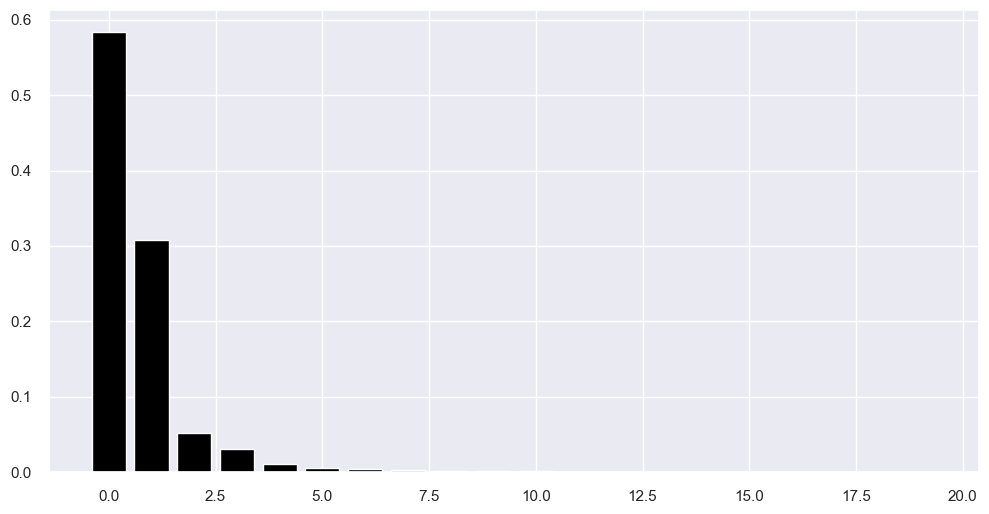

In [112]:
pca = PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')

df_pca = pd.DataFrame(principal_components)

<Axes: xlabel='0', ylabel='1'>

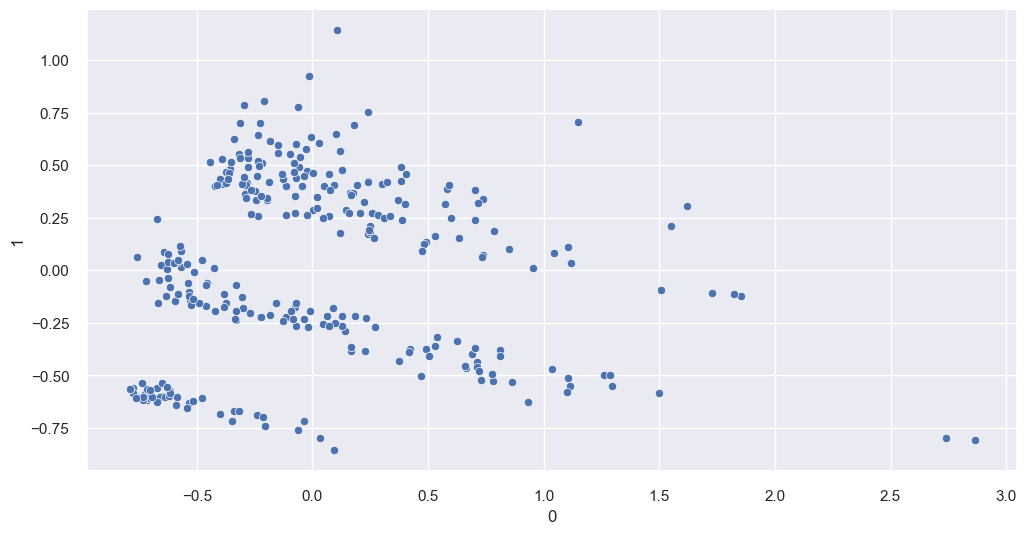

In [113]:
sns.scatterplot(x=0, y=1, data=df_pca)

## UMAP

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

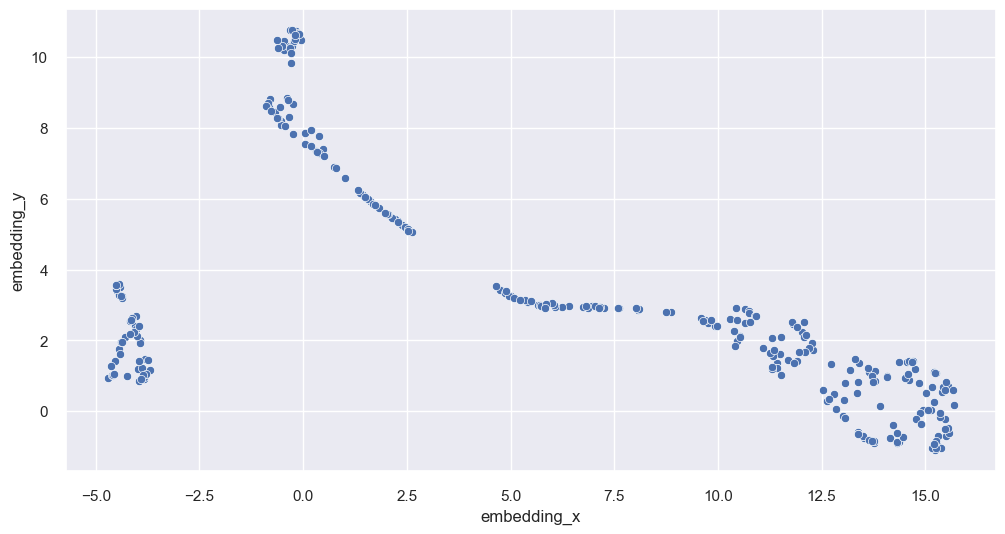

In [114]:
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
embedding = reducer.fit_transform(X)

#embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:,0]
df_umap['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                data=df_umap)

## t-SNE

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

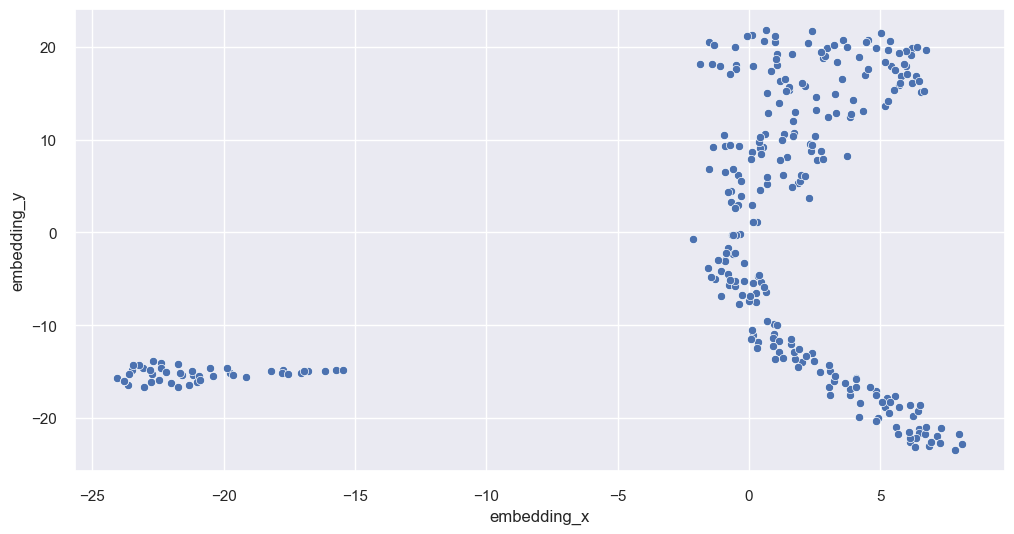

In [115]:
reducer = TSNE(n_components=2, random_state=42, n_jobs=-1)
embedding = reducer.fit_transform(X)

#embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:,0]
df_tsne['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                data=df_tsne)

## Tree-Embedding

In [116]:
X = X_train_emb_alvo.drop('faturamento', axis=1).copy()
y= X_train_emb_alvo['faturamento'].copy()

In [117]:
#model definition
rf = RandomForestRegressor(random_state=42, n_estimators=100, criterion='squared_error')

rf.fit(X, y)

RandomForestRegressor(random_state=42)

In [118]:
#create leafs
df_leafs = pd.DataFrame(rf.apply(X))

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

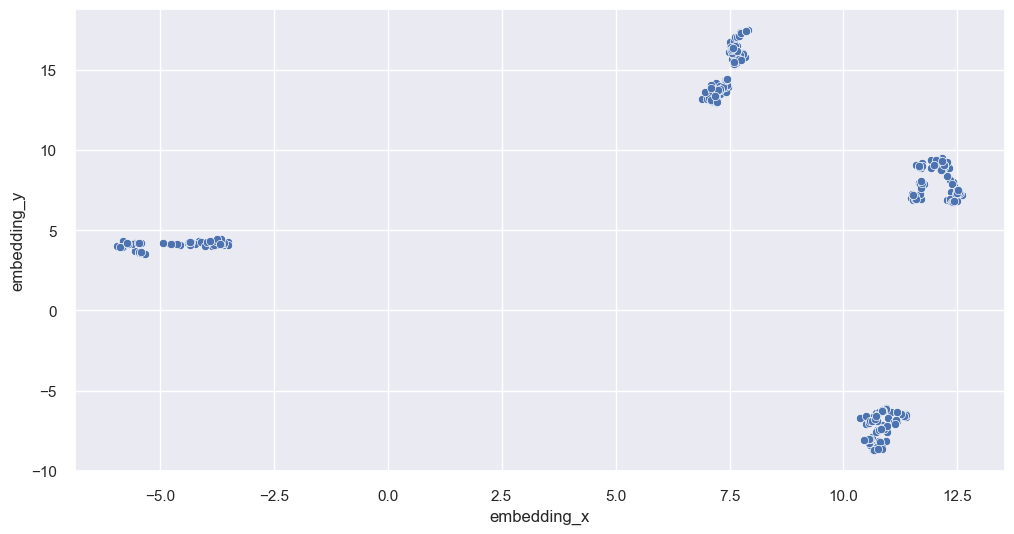

In [119]:
reducer = umap.UMAP(random_state=42, n_neighbors=120, min_dist=0.02)
embedding = reducer.fit_transform(df_leafs)

#embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:,0]
df_tree['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                data=df_tree)

## 12.1 Find Clusters

In [120]:
df12 = df_tree.copy()

In [121]:
clusters = np.arange(2,15,1)

Text(0.5, 1.0, 'WSS vs K')

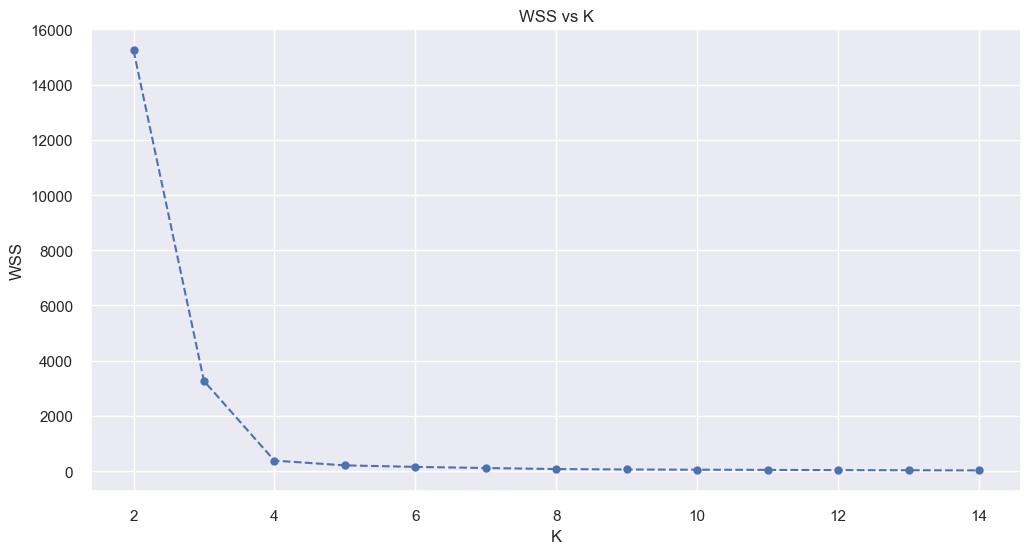

In [122]:
#WSS
wss = []

for k in clusters: 
    kmeans = KMeans(n_clusters=k, init='k-means++')

    kmeans.fit(df12)
    
    wss.append(kmeans.inertia_)
    
#elbow method
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('WSS')
plt.title('WSS vs K')

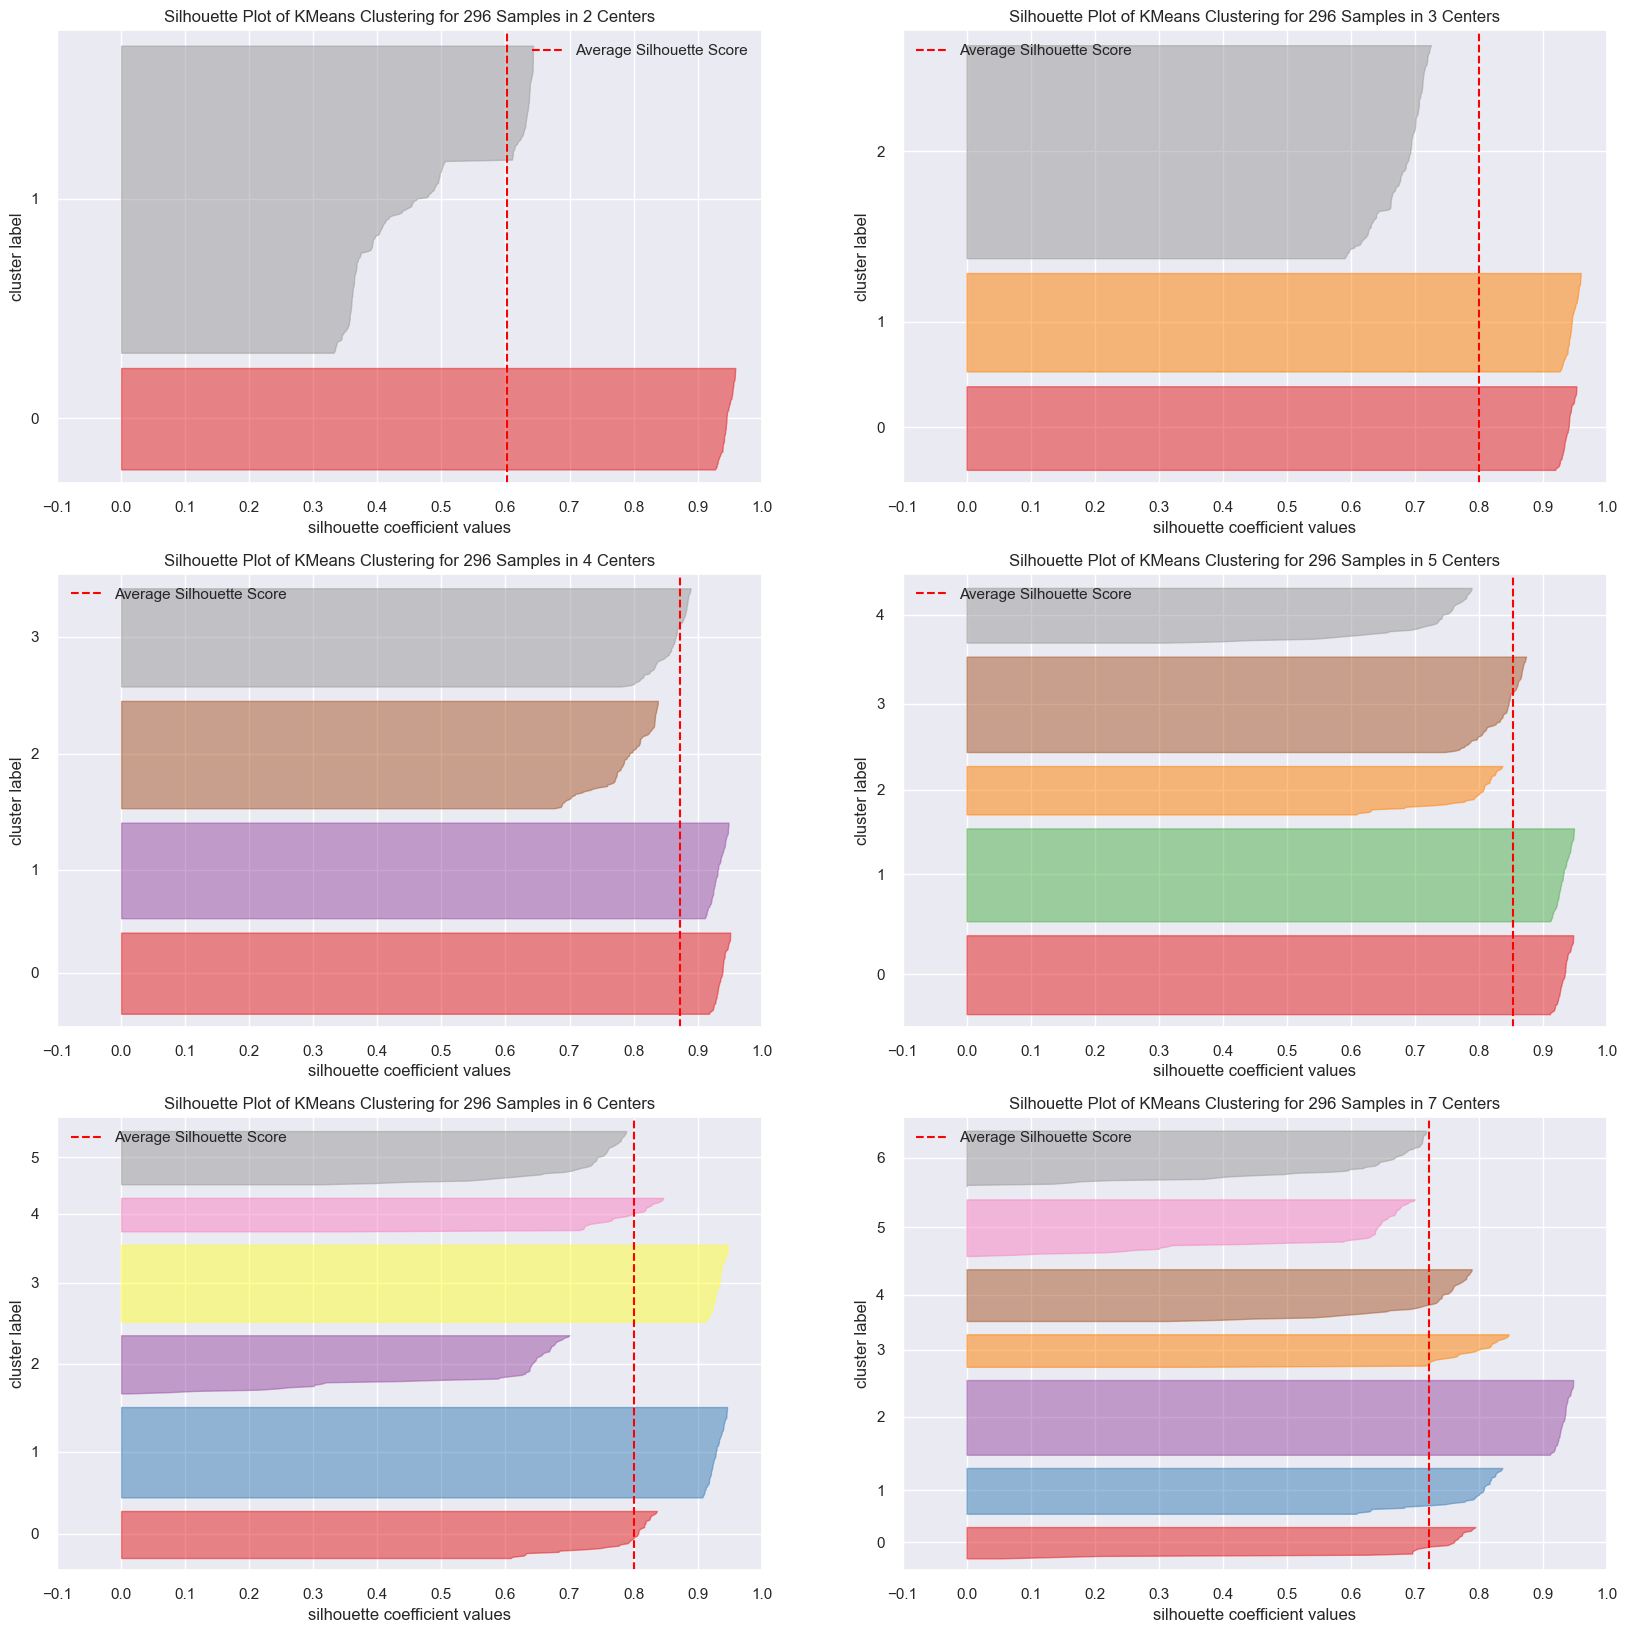

In [123]:
#SIlhouette
clusters = np.arange(2,8,1)
fig, ax = plt.subplots(3,2, figsize=(20,20))

for k in clusters:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=50, max_iter=300, random_state=42)
    q, mod = divmod(k,2)
    
    visualizer = SilhouetteVisualizer(kmeans, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df12)
    visualizer.finalize()

# 13 MODEL TRAINING

In [124]:
#kMEANS
k=4

kmeans = KMeans(n_clusters=k, init='k-means++', n_init=50, max_iter=300, random_state=42)

kmeans.fit(df12)

labels = kmeans.labels_

In [125]:

#WSS
print(f'WSS Score: {kmeans.inertia_:.3f}')

print(f'SS Score: {mt.silhouette_score(df12, labels):.3f}')

WSS Score: 379.186
SS Score: 0.873


In [126]:
df13 = df12.copy()
df13['clusters'] = labels

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

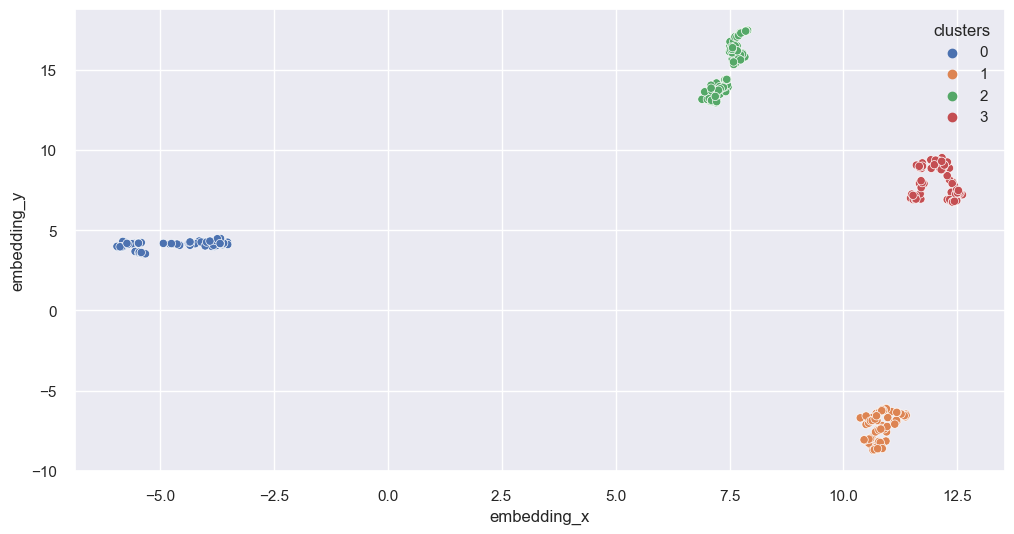

In [127]:
sns.scatterplot(data=df13, x="embedding_x", y="embedding_y", hue="clusters", palette="deep")

## 15.0 RESULTS

In [128]:
df14 = X_test_class_result.copy()
df14['clusters'] = labels

In [129]:
df14

,codigo,nome,cidade,estado,população,pop_ate9,pop_de10a14,pop_de15a19,pop_de20a24,pop_de25a34,pop_de35a49,pop_de50a59,pop_mais_de60,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,domicilios_c1,domicilios_c2,domicilios_d,domicilios_e,renda_media,faturamento,potencial,clusters
160,355030251,A. E. Carvalho,São Paulo,SP,94034,12668,6853,9836,7487,14535,21549,10598,10508,0,253,2197,4368,6681,7011,2247,5670,1501.0,2.177271e+05,2,0
161,35503020,Aclimação,São Paulo,SP,32791,2297,1017,2096,2197,5341,7281,4917,7645,1413,1734,3704,2351,1946,827,291,1617,5920.0,1.440078e+06,2,2
162,355030285,Adventista,São Paulo,SP,104193,15070,7343,10631,8657,17749,23364,11567,9812,0,0,1423,4875,8595,10082,3111,5776,1284.0,1.814055e+05,1,0
163,35503088,Água Branca,São Paulo,SP,12721,953,343,627,819,2142,2833,1790,3214,624,667,1558,1032,915,361,84,404,6278.0,1.234949e+06,1,2
164,35503066,Água Funda,São Paulo,SP,48417,5078,2396,4018,3571,7388,10751,6648,8567,0,303,1794,2986,4489,2836,1104,2553,1905.0,8.089814e+05,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,355030213,Vila Sônia,São Paulo,SP,34061,2908,1462,2253,2076,4579,7557,5227,7999,942,1089,2866,2219,2216,1227,306,1098,5285.0,1.356692e+06,2,2
452,355030207,Vila Suzana,São Paulo,SP,35403,4127,1890,2678,2433,5855,9107,4608,4705,1726,1522,2458,1186,1166,918,209,3840,7418.0,1.412882e+06,2,2
453,355030162,Vila Terezinha,São Paulo,SP,122359,18304,9304,13258,9965,19248,26592,12579,13109,0,0,1758,4517,9450,11473,3218,7540,1252.0,1.207730e+05,1,0
454,355030157,Vila Zatt,São Paulo,SP,125864,14670,7305,11225,9338,18841,28500,16700,19285,8,872,5093,8063,10012,8082,2856,6853,1936.0,2.670191e+05,2,0


In [138]:
df_renda = df14.loc[:,['clusters','renda_media']].groupby('clusters').mean().reset_index()

df_idade1 = df14.loc[:,['clusters','pop_de25a34']].groupby('clusters').mean().reset_index()

df_idade2 = df14.loc[:,['clusters','pop_de35a49']].groupby('clusters').mean().reset_index()

df_a1 = df14.loc[:,['clusters','domicilios_a1']].groupby('clusters').sum().reset_index()

df_a2 = df14.loc[:,['clusters','domicilios_a2']].groupby('clusters').sum().reset_index()

df_b1 = df14.loc[:,['clusters','domicilios_b1']].groupby('clusters').sum().reset_index()

df_b2 = df14.loc[:,['clusters','domicilios_b2']].groupby('clusters').sum().reset_index()

df_potencial = df14.loc[df14['potencial'] == 2,['clusters','potencial']].groupby('clusters').count().reset_index()



df_fat = df14.loc[:,['clusters','faturamento']].groupby('clusters').mean().reset_index()

df_resume = (pd.merge(df_renda, df_idade1, on='clusters', how='left')
              .merge(df_idade2, on='clusters', how='left')
              .merge(df_a1, on='clusters', how='left')
              .merge(df_a2, on='clusters', how='left')
              .merge(df_b1, on='clusters', how='left')
              .merge(df_b2, on='clusters', how='left')
              .merge(df_fat, on='clusters', how='left')
              .merge(df_potencial, on='clusters', how='left')
              
            )

In [140]:
df_resume.sort_values(by='faturamento', ascending=False)

,clusters,renda_media,pop_de25a34,pop_de35a49,domicilios_a1,domicilios_a2,domicilios_b1,domicilios_b2,faturamento,potencial
2,2,8427.903614,4082.108434,6069.734940,112043,114834,236356,133831,1.403401e+06,63
3,3,3832.761496,4106.736842,5824.381579,9997,36994,151118,150813,9.921677e+05,42
1,1,1659.418919,4536.540541,6531.472973,328,8555,75481,126231,7.743129e+05,15
0,0,1369.365079,14599.333333,20237.777778,422,7131,102826,255144,2.561040e+05,21


In [135]:
df14.loc[(df14['clusters'] == 2) & (df14['potencial'] == 2),['nome','potencial']]

,nome,potencial
161,Aclimação,2
165,Água Rasa,2
167,Alfredo Pujol,2
168,Alto Da Lapa,2
171,Ana Rosa,2
...,...,...
443,Vila Olímpia,2
445,Vila Prudente,2
448,Vila Santa Catarina,2
451,Vila Sônia,2
